# EDA of datasets used to describe cell lines and drugs

In [1]:
import numpy as np
import pandas as pd
import time
import sys
import dill

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset

## KINOMEscan dataset - only common kinases across drugs
Drugs described by kinase inhibtion profiles, cell lines by expression and coding variants correspinding to these kinases and tissue type - set of cell lines constititute to intersection of kinases screened for each drug

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### Load the data

In [42]:
# Load GDSC drug annotations
filepath = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Data/GDSC/Meta/"
col_names = ["drug_id", "Name", "Synonyms", "Targets", "Target pathway", "PubCHEM", "Dataset", "Sample Size",
            "Screening site", "Count"]
gdsc_drug_list = pd.read_csv(filepath + "Drug_listTue Nov  5 13_27_12 2019.csv", names=col_names,
                            skiprows=[0])
print(gdsc_drug_list.shape)
gdsc_drug_list.head(3)

(495, 10)


,drug_id,Name,Synonyms,Targets,Target pathway,PubCHEM,Dataset,Sample Size,Screening site,Count
0,1242,(5Z)-7-Oxozeaenol,"5Z-7-Oxozeaenol, LL-Z1640-2",TAK1,"Other, kinases",9863776,GDSC1,912,SANGER,495
1,179,5-Fluorouracil,5-FU,Antimetabolite (DNA & RNA),Other,3385,GDSC1,913,MGH,495
2,1073,5-Fluorouracil,5-FU,Antimetabolite (DNA & RNA),Other,3385,GDSC2,806,SANGER,495


In [43]:
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_dataset.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)

Kinases Dataset <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset. 
- Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
mutations in 18 genes. Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
- Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
- Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered 


In [44]:
# Extract drug data
drug_data = full_dataset.drugs_data.copy()
drug_data.index = full_dataset.drugs_data.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)
print(drug_data.shape)
drug_data.head(3)

(74, 294)


Protein,MAPKAPK2,MARK1,CAMKK2,MARK2,TGFBR1,ERK5,EPHA7,MK01,RAF1,TNNI3K,...,KGP1,ZAP70,ERK3,BLK,MYLK2,KPCD3,FGFR3,ACVR1,GSK3A,KPCD
Small Molecule,,,,,,,,,,,,,,,,,,,,,
1242,100.0,83.0,88.0,96.0,57.0,100.0,92.0,64.0,100.0,77.0,...,99.0,86.0,98.0,57.0,80.0,12.0,95.0,1.9,100.0,100.0
86,100.0,100.0,2.0,13.0,100.0,100.0,100.0,100.0,100.0,100.0,...,0.7,100.0,100.0,100.0,100.0,1.6,100.0,100.0,1.0,0.9
29,100.0,100.0,28.0,92.0,100.0,100.0,84.0,100.0,2.3,15.0,...,100.0,100.0,100.0,1.0,100.0,88.0,100.0,100.0,100.0,89.0


#### Extract pathway information for drug in the analysis

Number of unique target pathways: 14


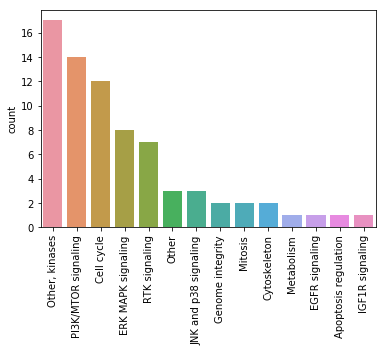

In [7]:
target_pathways = []
for drug_id in drug_data.index:
    df = gdsc_drug_list[gdsc_drug_list.drug_id == drug_id]
    pathway = df["Target pathway"].iloc[0]
    target_pathways.append(pathway)
target_pathways = pd.Series(data=target_pathways, index=drug_data.index)
n_pathways = target_pathways.nunique()
print("Number of unique target pathways:", n_pathways)

# Plot target pathways occurences
plt.xticks(rotation=90)
sns.countplot(target_pathways, order=target_pathways.value_counts().index)
plt.show()

#### Perform visualization of drug data with PCA alone

In [8]:
# Fit PCA object
n_latent = 2

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(drug_data)

# Setup and fit PCA
pca = PCA(n_components=n_latent)
transformed_drug_data = pca.fit_transform(X)
transformed_df = pd.DataFrame(data=transformed_drug_data, index=drug_data.index)
transformed_df["Target pathway"] = target_pathways

print(transformed_df.shape)
print("Variance explained by {} components: {}".format(n_latent, pca.explained_variance_ratio_.sum()))
transformed_df.head(3)

(74, 3)
Variance explained by 2 components: 0.4316177271091681


,0,1,Target pathway
Small Molecule,,,
1242,0.194851,-0.101140,"Other, kinases"
86,5.112263,17.845484,PI3K/MTOR signaling
29,1.631349,-12.214894,ERK MAPK signaling


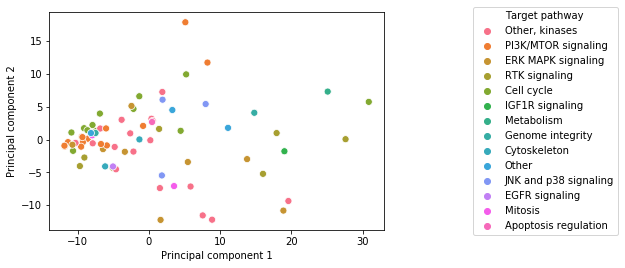

In [9]:
# Visualize on the scatter plot
g = sns.scatterplot(0, 1, data=transformed_df, hue="Target pathway", s=70)
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

#### Visualization with PCA for pathways seperately

In [46]:
df = drug_data.copy()
df.insert(0, "Target pathway", target_pathways)

Other, kinases alone

No handles with labels found to put in legend.


(17, 2)
Variance explained by 2 components: 0.365004830858332


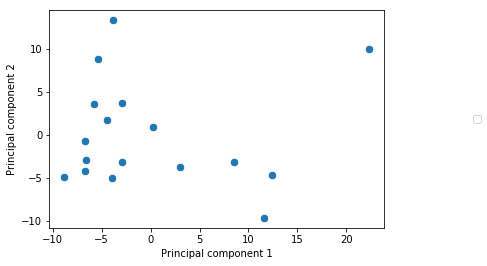

In [52]:
# Fit PCA object
n_latent = 2

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df[df["Target pathway"].isin(["Other, kinases"])].iloc[:, 1:])

# Setup and fit PCA
pca = PCA(n_components=n_latent)
transformed_drug_data = pca.fit_transform(X)

print(transformed_drug_data.shape)
print("Variance explained by {} components: {}".format(n_latent, pca.explained_variance_ratio_.sum()))
transformed_df = pd.DataFrame(data=transformed_drug_data)

# Visualize on the scatter plot
g = sns.scatterplot(0, 1, data=transformed_df, s=70)
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

Other pathways separtely

(57, 2)
Variance explained by 2 components: 0.4854176642043424


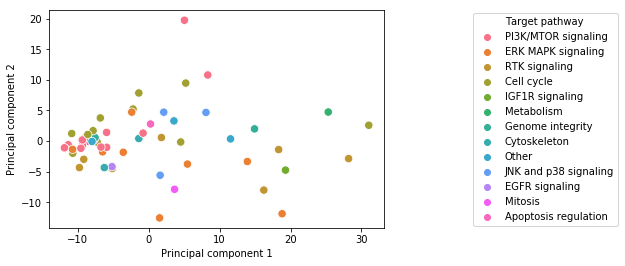

In [66]:
# Fit PCA object
n_latent = 2

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(df[~df["Target pathway"].isin(["Other, kinases"])].iloc[:, 1:])

# Setup and fit PCA
pca = PCA(n_components=n_latent)
transformed_drug_data = pca.fit_transform(X)

print(transformed_drug_data.shape)
print("Variance explained by {} components: {}".format(n_latent, pca.explained_variance_ratio_.sum()))
transformed_df = pd.DataFrame(data=transformed_drug_data, 
                              index=df[~df["Target pathway"].isin(["Other, kinases"])].index)

transformed_df["Target pathway"] = df[~df["Target pathway"].isin(["Other, kinases"])]["Target pathway"]

# Visualize on the scatter plot
g = sns.scatterplot(0, 1, data=transformed_df, hue="Target pathway", s=70)
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

#### Perform visualization of drug data with PCA combined with tSNE

In [27]:
# Fit PCA object
n_latent = n_pathways

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(drug_data)

# Setup and fit PCA
pca = PCA(n_components=n_latent)
transformed_drug_data = pca.fit_transform(X)

print(transformed_drug_data.shape)
print("Variance explained by {} components: {}".format(n_latent, pca.explained_variance_ratio_.sum()))
transformed_df.head(3)

(74, 14)
Variance explained by 14 components: 0.7514040024206559


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Small Molecule,,,,,,,,,,,,,,
1242,0.194851,-0.101140,-1.506223,-1.214389,-1.863848,-0.952668,-4.833841,-1.707526,2.123955,0.975320,0.343341,3.469178,3.564133,-0.331227
86,5.112263,17.845484,-7.241976,6.533610,-3.495758,7.437371,10.467546,-0.857677,2.263892,-1.606770,-6.012155,4.149884,-1.978699,-0.073738
29,1.631349,-12.214894,-6.601171,0.447793,-0.209231,-4.315168,3.398606,-3.806774,-1.011489,-1.367761,-0.444396,0.998431,-0.700037,-1.424201


In [28]:
# Further reduce dimensions with TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
transformed_drug_data = tsne.fit_transform(transformed_drug_data)

transformed_df = pd.DataFrame(data=transformed_drug_data, index=drug_data.index)
transformed_df["Target pathway"] = target_pathways

print(transformed_df.shape)
transformed_df.head(3)

(74, 3)


,0,1,Target pathway
Small Molecule,,,
1242,-3.130216,-1.864260,"Other, kinases"
86,-5.657876,0.606160,PI3K/MTOR signaling
29,-5.826050,-2.019298,ERK MAPK signaling


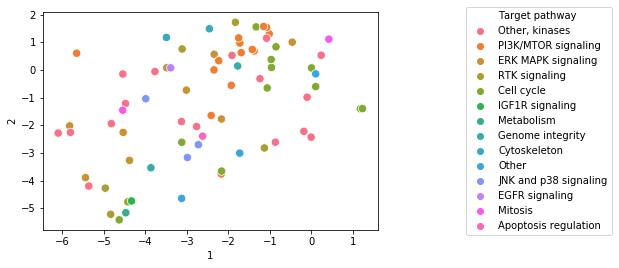

In [30]:
# Visualize on the scatter plot
g = sns.scatterplot(0, 1, data=transformed_df, hue="Target pathway", s=70)
plt.xlabel("1")
plt.ylabel("2")
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

#### Perform visualization of cell line data with PCA alone

In [33]:
# Extract cell line data
cell_line_data = full_dataset.full_cell_lines_data.copy()
print(cell_line_data.shape)
cell_line_data.head(3)

(922, 225)


,cell_line_id,PRKX_exp,TIE1_exp,BMPR2_exp,PKMYT1_exp,ABL2_exp,PLK1_exp,ACVR1_exp,MAP3K4_mut,SRPK1_exp,...,Tissue_lung_SCLC,Tissue_lymphoma,Tissue_myeloma,Tissue_nervous_system,Tissue_neuroblastoma,Tissue_pancreas,Tissue_skin,Tissue_soft_tissue,Tissue_thyroid,Tissue_urogenital_system
cell_line_id,,,,,,,,,,,,,,,,,,,,,
906826,906826,4.787607,3.056350,6.395463,5.550737,5.492917,3.853142,4.384087,0,7.410108,...,0,0,0,0,0,0,0,0,0,0
687983,687983,5.001763,3.125097,6.634672,5.399054,5.113815,4.218736,4.786061,0,7.776150,...,1,0,0,0,0,0,0,0,0,0
910927,910927,5.459631,2.989998,7.945827,5.541005,4.519127,3.694307,4.414635,0,7.079021,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# Train PCA on all features
n_latent = 2

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(cell_line_data.iloc[:, 1:])

# Setup and fit PCA
pca = PCA(n_components=n_latent)
transformed_cell_line_data = pca.fit_transform(X)
transformed_df = pd.DataFrame(data=transformed_cell_line_data, index=cell_line_data.index)

print(transformed_df.shape)
print("Variance explained by {} components: {}".format(n_latent, pca.explained_variance_ratio_.sum()))
transformed_df.head(3)

(922, 2)
Variance explained by 2 components: 0.1369082674407538


,0,1
cell_line_id,,
906826,-3.304686,1.416109
687983,1.209142,3.986931
910927,-2.878905,-0.360645


No handles with labels found to put in legend.


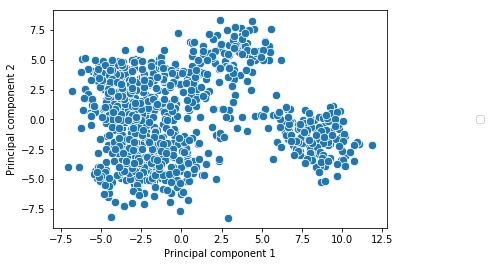

In [38]:
# Visualize on the scatter plot
g = sns.scatterplot(0, 1, data=transformed_df, s=70)
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()